In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from string import punctuation
from nltk.tokenize import word_tokenize
from keras.utils import to_categorical
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import log_loss
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt


In [33]:
df_full = pd.read_csv('/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv')
df_full.drop(['Clothing ID'],inplace = True, axis = 1)
# Add 'words count' column
df_full['words count'] = df_full['Review Text'].fillna('').apply(lambda x: len(x.split(' ')))
df_full['words count'].describe()

count    23486.000000
mean        58.084391
std         30.080991
min          1.000000
25%         34.000000
50%         57.000000
75%         87.000000
max        115.000000
Name: words count, dtype: float64

In [34]:
df_full

Unnamed: 0  Age                                              Title                                        Review Text  Rating  Recommended IND  Positive Feedback Count   Division Name Department Name Class Name  words count
0               0   33                                                NaN  Absolutely wonderful - silky and sexy and comf...       4                1                        0       Initmates        Intimate  Intimates            8
1               1   34                                                NaN  Love this dress!  it's sooo pretty.  i happene...       5                1                        4         General         Dresses    Dresses           67
2               2   60                            Some major design flaws  I had such high hopes for this dress and reall...       3                0                        0         General         Dresses    Dresses           98
3               3   50                                   My favorite buy!  I love, love, love this jumpsuit. it's fun, fl...       5                1                        0  General Petite         Bottoms      Pants           22
4               4   47                                   Flattering shirt  This shirt is very flattering to all due to th...       5                1                        6         General            Tops    Blouses           36
...           ...  ...                                                ...                                                ...     ...              ...                      ...             ...             ...        ...          ...
23481       23481   34                     Great dress for many occasions  I was very happy to snag this dress at such a ...       5                1                        0  General Petite         Dresses    Dresses           28
23482       23482   48                         Wish it was made of cotton  It reminds me of maternity clothes. soft, stre...       3                1                        0  General Petite            Tops      Knits           37
23483       23483   31                              Cute, but see through  This fit well, but the top was very see throug...       3                0                        1  General Petite         Dresses    Dresses           42
23484       23484   28  Very cute dress, perfect for summer parties an...  I bought this dress for a wedding i have this ...       3                1                        2         General         Dresses    Dresses           86
23485       23485   52                    Please make more like this one!  This dress in a lovely platinum is feminine an...       5                1                       22  General Petite         Dresses    Dresses           19

[23486 rows x 11 columns]

In [35]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 1000)

### Check Missing Value 

In [36]:
df_full.isna().sum()

Unnamed: 0                    0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
words count                   0
dtype: int64

## To see joint frequency on Recommended IND and Rating

In [37]:
df_full[['Recommended IND','Rating']].value_counts().sort_index()

Recommended IND  Rating
0                1           826
                 2          1471
                 3          1682
                 4           168
                 5            25
1                1            16
                 2            94
                 3          1189
                 4          4909
                 5         13106
Name: count, dtype: int64

In [38]:
df_full = df_full.dropna(subset= ['Review Text','Division Name','Department Name','Class Name'])

In [39]:
print(df_full['Division Name'].value_counts())
print()
print(df_full['Department Name'].value_counts())
print()
print(df_full['Class Name'].value_counts())

Division Name
General           13365
General Petite     7837
Initmates          1426
Name: count, dtype: int64

Department Name
Tops        10048
Dresses      6145
Bottoms      3662
Intimate     1653
Jackets      1002
Trend         118
Name: count, dtype: int64

Class Name
Dresses           6145
Knits             4626
Blouses           2983
Sweaters          1380
Pants             1350
Jeans             1104
Fine gauge        1059
Skirts             903
Jackets            683
Lounge             669
Swim               332
Outerwear          319
Shorts             304
Sleep              214
Legwear            158
Intimates          147
Layering           132
Trend              118
Casual bottoms       1
Chemises             1
Name: count, dtype: int64


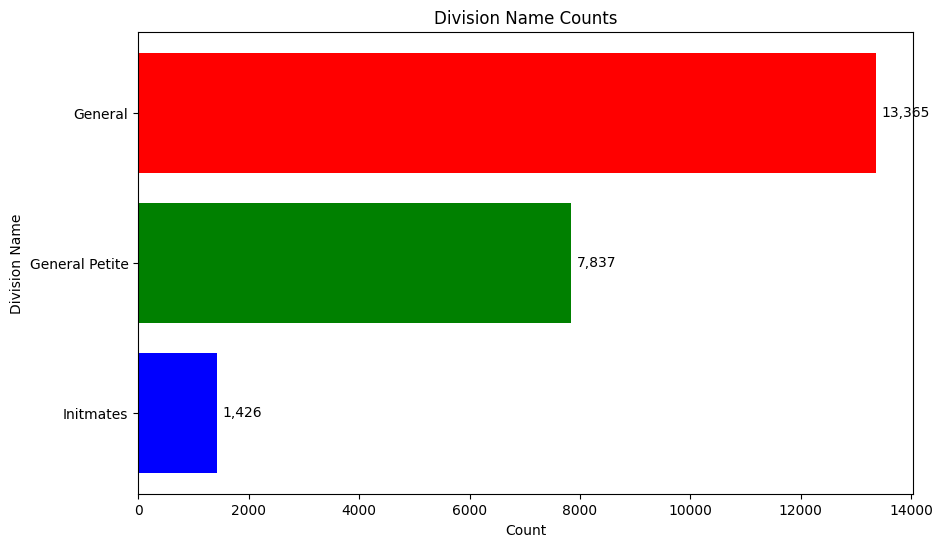

In [40]:
# Get value counts
division_counts = df_full['Division Name'].value_counts().sort_values()
# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(division_counts.index, division_counts.values, color=['blue', 'green', 'red'])

# Add labels to each bar
for bar in bars:
    plt.text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():,.0f}', va='center', ha='left')

plt.title('Division Name Counts')
plt.xlabel('Count')
plt.ylabel('Division Name')
plt.show()

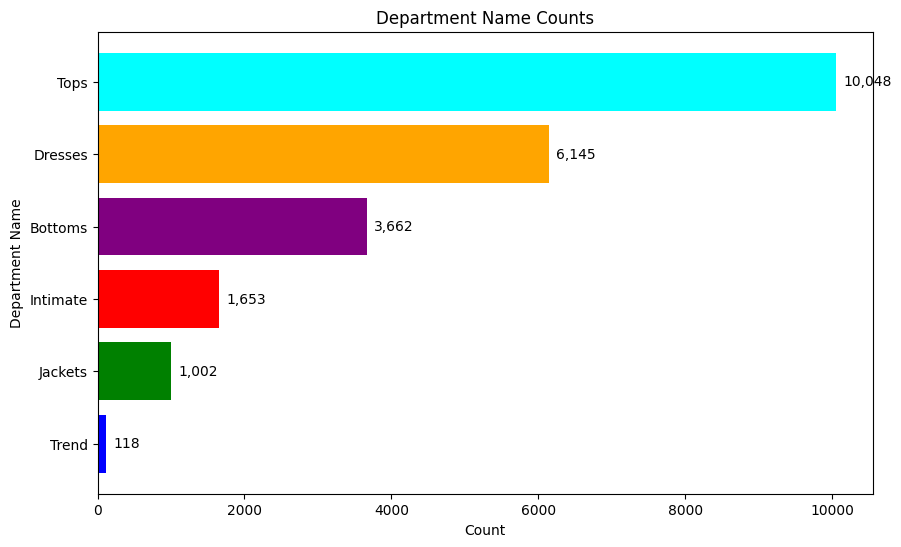

In [41]:
# Get value counts
department_counts = df_full['Department Name'].value_counts().sort_values()

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(department_counts.index, department_counts.values, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])

# Add labels to each bar
for bar in bars:
    plt.text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():,.0f}', va='center', ha='left')

plt.title('Department Name Counts')
plt.xlabel('Count')
plt.ylabel('Department Name')
plt.show()

In [42]:
## Drop the row for casual bottom and chemises
df_full = df_full.query("`Class Name` != 'Casual bottoms' and `Class Name` != 'Chemises'")

In [43]:
zero_labels_count = df_full['Recommended IND'].value_counts()[0]
one_labels_count = df_full['Recommended IND'].value_counts()[1]
total = zero_labels_count + one_labels_count
print(f"zero: {zero_labels_count} -> {zero_labels_count/total:.2%}, one:{one_labels_count} {one_labels_count/total:.2%}")

zero: 4101 -> 18.13%, one:18525 81.87%


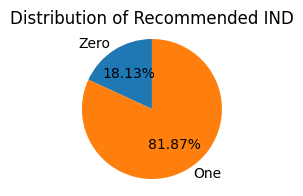

In [44]:
import matplotlib.pyplot as plt

# Calculate counts and percentages
zero_labels_count = df_full['Recommended IND'].value_counts()[0]
one_labels_count = df_full['Recommended IND'].value_counts()[1]
total = zero_labels_count + one_labels_count
zero_percentage = zero_labels_count / total
one_percentage = one_labels_count / total

# Create labels and sizes for the pie chart
labels = ['Zero', 'One']
sizes = [zero_labels_count, one_labels_count]
percentages = [zero_percentage, one_percentage]

# Plotting
plt.figure(figsize=(3, 2))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)
plt.title('Distribution of Recommended IND')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Preprocessing
### Remove Punctuation

In [45]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

nlp = spacy.load("en_core_web_sm")

def extract_adjectives(text):
    # Process the text
    doc = nlp(text)
    # Extract adjectives
    adjectives = [token.text for token in doc if token.pos_ == 'ADJ']
    return ' '.join(adjectives)

# Apply the function to fill in missing titles
df_full['Title'] = df_full.apply(
    lambda row: extract_adjectives(row['Review Text']) if pd.isna(row['Title']) else row['Title'],
    axis=1
)

In [46]:
# All title now only have adjectives
df_full['Title'] = df_full['Title'].apply(extract_adjectives) 

In [47]:
df_full["Preprocessed Review Text"] = df_full["Review Text"].astype(str).apply(lambda text: remove_punctuation(text))
df_full["Preprocessed Title"] = df_full["Title"].astype(str).apply(lambda text: remove_punctuation(text))
df_full["Combined Preprocessed"] = df_full["Preprocessed Review Text"].apply(lambda text: text.lower()) + " " + df_full["Preprocessed Title"].apply(lambda text: text.lower())

all_features = df_full['Combined Preprocessed'].astype(str).str.lower()
review_features = df_full["Preprocessed Review Text"].astype(str).str.lower()
title_features = df_full["Preprocessed Title"].astype(str).str.lower()

# Machine Learning Approach using Logistic Regression

In [48]:
import numpy as np
import pandas as pd
import re
# from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_auc_score

In [49]:
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [50]:
glove_file_path_50 = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt'
glove_file_path_100 = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'
glove_file_path_200 = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
glove_embeddings_50 = load_glove_embeddings(glove_file_path_50)
glove_embeddings_100 = load_glove_embeddings(glove_file_path_100)
glove_embeddings_200 = load_glove_embeddings(glove_file_path_200)

In [52]:
# Function to convert text to GloVe embeddings
def text_to_glove(text, glove_embeddings, embedding_dim=200, stat = 'mean'):
    words = text.split()
    word_vectors = [glove_embeddings[word] for word in words if word in glove_embeddings]
    if not word_vectors:  # If no words are in GloVe, return a zero vector
        return np.zeros(embedding_dim)
    if stat == 'mean':
        return np.mean(word_vectors, axis=0)
    elif stat == 'median':
        return np.median(word_vectors, axis=0)
    elif stat == 'max':
        return np.max(word_vectors, axis = 0)
    elif stat == 'midpoint':
        return (np.max(word_vectors, axis=0) - np.min(word_vectors, axis=0)) / 2
    elif stat == 'abs':
        return np.max(np.abs(word_vectors), axis = 0)

In [53]:
X_1_50d = np.array([text_to_glove(text, glove_embeddings_50) for text in df_full['Combined Preprocessed']])
X_1_100d = np.array([text_to_glove(text, glove_embeddings_100) for text in df_full['Combined Preprocessed']])
X_1_200d = np.array([text_to_glove(text, glove_embeddings_200) for text in df_full['Combined Preprocessed']])
X_1_200d_median = np.array([text_to_glove(text,glove_embeddings_200,stat='median') for text in df_full['Combined Preprocessed']])
X_1_200d_max = np.array([text_to_glove(text,glove_embeddings_200,stat='max') for text in df_full['Combined Preprocessed']])
X_1_200d_midpoint = np.array([text_to_glove(text,glove_embeddings_200,stat='midpoint') for text in df_full['Combined Preprocessed']])
X_1_200d_abs = np.array([text_to_glove(text,glove_embeddings_200,stat='abs') for text in df_full['Combined Preprocessed']])

X_2 = df_full[['Rating']].to_numpy()
X_50 = np.hstack((X_1_50d,X_2))
X_100 = np.hstack((X_1_100d,X_2))
X_200 = np.hstack((X_1_200d,X_2))



## SMOTE NC with rating

In [54]:
sm = SMOTENC(sampling_strategy ='minority',random_state=42, categorical_features=[50])
X_res_50d, y_res_50d = sm.fit_resample(X_50, df_full['Recommended IND'])

sm = SMOTENC(sampling_strategy ='minority',random_state=42, categorical_features=[100])
X_res_100d, y_res_100d = sm.fit_resample(X_100, df_full['Recommended IND'])

sm = SMOTENC(sampling_strategy ='minority',random_state=42, categorical_features=[200])
X_res_200d, y_res_200d = sm.fit_resample(X_200, df_full['Recommended IND'])


## SMOTE without rating

In [55]:
sm = SMOTE(random_state = 42)
X_res_50, y_res_50 = sm.fit_resample(X_1_50d, df_full['Recommended IND'])
X_res_100, y_res_100 = sm.fit_resample(X_1_100d,df_full['Recommended IND'])
X_res_200, y_res_200 = sm.fit_resample(X_1_200d,df_full['Recommended IND'])
# median, max, midpoint, and abs max
X_res_median,y_res_median = sm.fit_resample(X_1_200d_median,df_full['Recommended IND'])
X_res_max,y_res_max = sm.fit_resample(X_1_200d_max,df_full['Recommended IND'])
X_res_midpoint,y_res_midpoint = sm.fit_resample(X_1_200d_midpoint,df_full['Recommended IND'])
X_res_abs, y_res_abs = sm.fit_resample(X_1_200d_abs, df_full['Recommended IND'])

In [56]:
def eval_model(y_true,y_pred):
    # Evaluate the model
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

## Without SMOTE

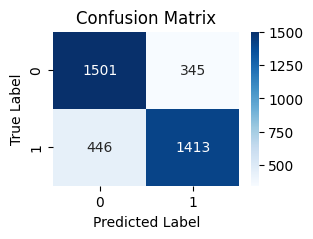

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_res_50, y_res_50,test_size = 0.1)
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Experiments

In [58]:
## function for logistic regression
def direct_train(X,y):
    X_train, X_test,y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state = 42)
    model = LogisticRegression(max_iter = 10000)
    model.fit(X_train,y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print('Test Metrics')
    eval_model(y_test,y_pred_test)
    print('Train Metrics')
    eval_model(y_train,y_pred_train)
    y_pred_proba_test = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    # Calculate binary cross-entropy loss
    loss_test = log_loss(y_test, y_pred_proba_test)
    print(f'Binary Cross-Entropy Loss test: {loss_test}')
    loss_train = log_loss(y_train, y_pred_proba_train)
    print(f'Binary Cross-Entropy Loss train: {loss_train}')
    return model

## 50D + mean pooling with rating 

In [59]:
direct_train(X_res_50d, y_res_50d)

Test Metrics
Accuracy: 0.961
Precision: 0.979
Recall: 0.939
F1 Score: 0.959

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1904
           1       0.98      0.94      0.96      1801

    accuracy                           0.96      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.96      0.96      0.96      3705

Train Metrics
Accuracy: 0.957
Precision: 0.981
Recall: 0.932
F1 Score: 0.956

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     16621
           1       0.98      0.93      0.96     16724

    accuracy                           0.96     33345
   macro avg       0.96      0.96      0.96     33345
weighted avg       0.96      0.96      0.96     33345

Binary Cross-Entropy Loss test: 0.13982498492359632
Binary Cross-Entropy Loss train: 0.14596910445321673


LogisticRegression(max_iter=10000)

### Confusion Matrix With SMOTE

In [60]:
y_pred_glove= model_mean_glove.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_glove)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'model_mean_glove' is not defined


## 100d with rating

In [ ]:
direct_train(X_res_100d, y_res_100d)

## 200d with rating

In [ ]:
direct_train(X_res_200d, y_res_200d)

## 50d without rating

In [61]:
direct_train(X_res_50, y_res_50 ) 

Test Metrics
Accuracy: 0.777
Precision: 0.785
Recall: 0.745
F1 Score: 0.764

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1904
           1       0.79      0.74      0.76      1801

    accuracy                           0.78      3705
   macro avg       0.78      0.78      0.78      3705
weighted avg       0.78      0.78      0.78      3705

Train Metrics
Accuracy: 0.790
Precision: 0.807
Recall: 0.764
F1 Score: 0.785

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79     16621
           1       0.81      0.76      0.79     16724

    accuracy                           0.79     33345
   macro avg       0.79      0.79      0.79     33345
weighted avg       0.79      0.79      0.79     33345

Binary Cross-Entropy Loss test: 0.46313887497542294
Binary Cross-Entropy Loss train: 0.46149960478230995


LogisticRegression(max_iter=10000)

## 100D Without Rating

In [62]:
direct_train(X_res_100, y_res_100 )

Test Metrics
Accuracy: 0.821
Precision: 0.830
Recall: 0.794
F1 Score: 0.812

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1904
           1       0.83      0.79      0.81      1801

    accuracy                           0.82      3705
   macro avg       0.82      0.82      0.82      3705
weighted avg       0.82      0.82      0.82      3705

Train Metrics
Accuracy: 0.828
Precision: 0.845
Recall: 0.804
F1 Score: 0.824

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83     16621
           1       0.85      0.80      0.82     16724

    accuracy                           0.83     33345
   macro avg       0.83      0.83      0.83     33345
weighted avg       0.83      0.83      0.83     33345

Binary Cross-Entropy Loss test: 0.40625668161006845
Binary Cross-Entropy Loss train: 0.39886706208874256


LogisticRegression(max_iter=10000)

In [63]:
direct_train(X_res_200, y_res_200)

Test Metrics
Accuracy: 0.848
Precision: 0.857
Recall: 0.825
F1 Score: 0.840

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1904
           1       0.86      0.82      0.84      1801

    accuracy                           0.85      3705
   macro avg       0.85      0.85      0.85      3705
weighted avg       0.85      0.85      0.85      3705

Train Metrics
Accuracy: 0.850
Precision: 0.868
Recall: 0.825
F1 Score: 0.846

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85     16621
           1       0.87      0.82      0.85     16724

    accuracy                           0.85     33345
   macro avg       0.85      0.85      0.85     33345
weighted avg       0.85      0.85      0.85     33345

Binary Cross-Entropy Loss test: 0.36682351017297793
Binary Cross-Entropy Loss train: 0.35991077225102497


LogisticRegression(max_iter=10000)

## another pooling approach

In [64]:
direct_train(X_res_median,y_res_median) ## median pooling

Test Metrics
Accuracy: 0.827
Precision: 0.832
Recall: 0.806
F1 Score: 0.819

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1904
           1       0.83      0.81      0.82      1801

    accuracy                           0.83      3705
   macro avg       0.83      0.83      0.83      3705
weighted avg       0.83      0.83      0.83      3705

Train Metrics
Accuracy: 0.830
Precision: 0.848
Recall: 0.805
F1 Score: 0.826

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83     16621
           1       0.85      0.81      0.83     16724

    accuracy                           0.83     33345
   macro avg       0.83      0.83      0.83     33345
weighted avg       0.83      0.83      0.83     33345

Binary Cross-Entropy Loss test: 0.3984869382742542
Binary Cross-Entropy Loss train: 0.3897254276677434


LogisticRegression(max_iter=10000)

In [65]:
direct_train(X_res_max,y_res_max) ## max pooling

Test Metrics
Accuracy: 0.775
Precision: 0.779
Recall: 0.751
F1 Score: 0.765

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79      1904
           1       0.78      0.75      0.76      1801

    accuracy                           0.78      3705
   macro avg       0.78      0.77      0.77      3705
weighted avg       0.78      0.78      0.78      3705

Train Metrics
Accuracy: 0.791
Precision: 0.798
Recall: 0.780
F1 Score: 0.789

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     16621
           1       0.80      0.78      0.79     16724

    accuracy                           0.79     33345
   macro avg       0.79      0.79      0.79     33345
weighted avg       0.79      0.79      0.79     33345

Binary Cross-Entropy Loss test: 0.4808772836219143
Binary Cross-Entropy Loss train: 0.4556048585767725


LogisticRegression(max_iter=10000)

In [66]:
direct_train(X_res_midpoint,y_res_midpoint)## midpoint pooling

Test Metrics
Accuracy: 0.758
Precision: 0.755
Recall: 0.743
F1 Score: 0.749

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1904
           1       0.76      0.74      0.75      1801

    accuracy                           0.76      3705
   macro avg       0.76      0.76      0.76      3705
weighted avg       0.76      0.76      0.76      3705

Train Metrics
Accuracy: 0.763
Precision: 0.767
Recall: 0.758
F1 Score: 0.762

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76     16621
           1       0.77      0.76      0.76     16724

    accuracy                           0.76     33345
   macro avg       0.76      0.76      0.76     33345
weighted avg       0.76      0.76      0.76     33345

Binary Cross-Entropy Loss test: 0.5005037641953245
Binary Cross-Entropy Loss train: 0.48836131783529974


LogisticRegression(max_iter=10000)

In [67]:
direct_train(X_res_abs,y_res_abs) ## abs max pooling

Test Metrics
Accuracy: 0.764
Precision: 0.758
Recall: 0.754
F1 Score: 0.756

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1904
           1       0.76      0.75      0.76      1801

    accuracy                           0.76      3705
   macro avg       0.76      0.76      0.76      3705
weighted avg       0.76      0.76      0.76      3705

Train Metrics
Accuracy: 0.769
Precision: 0.776
Recall: 0.758
F1 Score: 0.767

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77     16621
           1       0.78      0.76      0.77     16724

    accuracy                           0.77     33345
   macro avg       0.77      0.77      0.77     33345
weighted avg       0.77      0.77      0.77     33345

Binary Cross-Entropy Loss test: 0.5029382779517988
Binary Cross-Entropy Loss train: 0.4872493543445885


LogisticRegression(max_iter=10000)

# BOW

## TF and TFIDF

In [68]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTEN, SMOTE, RandomOverSampler

## BOW without Rating

In [69]:
count_vect = CountVectorizer(min_df = 10)
tfidf_vect = TfidfVectorizer(min_df = 10)

X_count = count_vect.fit_transform(df_full['Combined Preprocessed'])
X_tfidf = tfidf_vect.fit_transform(df_full['Combined Preprocessed'])
y = df_full['Recommended IND']

sm_count = SMOTE(random_state = 42)
sm_tfidf = SMOTE(random_state = 42)

X_count_res, y_count_res = sm_count.fit_resample(X_count, y)
X_tfidf_res, y_tfidf_res = sm_tfidf.fit_resample(X_tfidf, y)

In [70]:
direct_train(X_count_res, y_count_res)

Test Metrics
Accuracy: 0.926
Precision: 0.923
Recall: 0.924
F1 Score: 0.924

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1904
           1       0.92      0.92      0.92      1801

    accuracy                           0.93      3705
   macro avg       0.93      0.93      0.93      3705
weighted avg       0.93      0.93      0.93      3705

Train Metrics
Accuracy: 0.960
Precision: 0.963
Recall: 0.957
F1 Score: 0.960

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     16621
           1       0.96      0.96      0.96     16724

    accuracy                           0.96     33345
   macro avg       0.96      0.96      0.96     33345
weighted avg       0.96      0.96      0.96     33345

Binary Cross-Entropy Loss test: 0.22444123807652974
Binary Cross-Entropy Loss train: 0.11687925611286507


LogisticRegression(max_iter=10000)

In [71]:
direct_train(X_tfidf_res, y_tfidf_res)

Test Metrics
Accuracy: 0.924
Precision: 0.941
Recall: 0.901
F1 Score: 0.921

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1904
           1       0.94      0.90      0.92      1801

    accuracy                           0.92      3705
   macro avg       0.93      0.92      0.92      3705
weighted avg       0.93      0.92      0.92      3705

Train Metrics
Accuracy: 0.928
Precision: 0.945
Recall: 0.909
F1 Score: 0.927

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     16621
           1       0.95      0.91      0.93     16724

    accuracy                           0.93     33345
   macro avg       0.93      0.93      0.93     33345
weighted avg       0.93      0.93      0.93     33345

Binary Cross-Entropy Loss test: 0.23470245004576293
Binary Cross-Entropy Loss train: 0.216945308021334


LogisticRegression(max_iter=10000)

## GloVe 200D + TF and GloVe 200D + TFIDF

In [72]:
X_final_tf_200d = np.hstack((X_1_200d,X_count.toarray()))
X_final_tfidf_200d = np.hstack((X_1_200d,X_tfidf.toarray()))
X_res_tf,y_res_tf = sm.fit_resample(X_final_tf_200d, df_full['Recommended IND'])
X_res_tfidf,y_res_tfidf = sm.fit_resample(X_final_tfidf_200d, df_full['Recommended IND'])

In [73]:
direct_train(X_res_tf,y_res_tf)

Test Metrics
Accuracy: 0.934
Precision: 0.950
Recall: 0.913
F1 Score: 0.931

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1904
           1       0.95      0.91      0.93      1801

    accuracy                           0.93      3705
   macro avg       0.94      0.93      0.93      3705
weighted avg       0.93      0.93      0.93      3705

Train Metrics
Accuracy: 0.960
Precision: 0.972
Recall: 0.947
F1 Score: 0.959

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     16621
           1       0.97      0.95      0.96     16724

    accuracy                           0.96     33345
   macro avg       0.96      0.96      0.96     33345
weighted avg       0.96      0.96      0.96     33345

Binary Cross-Entropy Loss test: 0.1959792745052856
Binary Cross-Entropy Loss train: 0.12858650545558303


LogisticRegression(max_iter=10000)

In [74]:
direct_train(X_res_tfidf,y_res_tfidf)

Test Metrics
Accuracy: 0.927
Precision: 0.944
Recall: 0.904
F1 Score: 0.924

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1904
           1       0.94      0.90      0.92      1801

    accuracy                           0.93      3705
   macro avg       0.93      0.93      0.93      3705
weighted avg       0.93      0.93      0.93      3705

Train Metrics
Accuracy: 0.928
Precision: 0.946
Recall: 0.908
F1 Score: 0.927

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     16621
           1       0.95      0.91      0.93     16724

    accuracy                           0.93     33345
   macro avg       0.93      0.93      0.93     33345
weighted avg       0.93      0.93      0.93     33345

Binary Cross-Entropy Loss test: 0.22885660462054225
Binary Cross-Entropy Loss train: 0.2114563093383823


LogisticRegression(max_iter=10000)

## BOW with Rating

In [83]:
count_vect = CountVectorizer(min_df = 10)
tfidf_vect = TfidfVectorizer(min_df = 10)

X_count = count_vect.fit_transform(df_full['Combined Preprocessed'])
X_tfidf = tfidf_vect.fit_transform(df_full['Combined Preprocessed'])
X_count = X_count.toarray()
X_tfidf = X_tfidf.toarray()
X_count = np.array(X_count)
X_tfidf = np.array(X_tfidf)
rating = np.array(df_full['Rating']).reshape(-1,1)
X_count = np.hstack((X_count,rating))
X_tfidf = np.hstack((X_tfidf,rating))
y = df_full['Recommended IND']


sm_count = SMOTE(random_state = 42)
sm_tfidf = SMOTE(random_state = 42)

X_count_res, y_count_res = sm_count.fit_resample(X_count, y)
X_tfidf_res, y_tfidf_res = sm_tfidf.fit_resample(X_tfidf, y)


In [79]:
direct_train(X_count_res, y_count_res)

Test Metrics
Accuracy: 0.957
Precision: 0.951
Recall: 0.961
F1 Score: 0.956

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1904
           1       0.95      0.96      0.96      1801

    accuracy                           0.96      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.96      0.96      0.96      3705

Train Metrics
Accuracy: 0.983
Precision: 0.986
Recall: 0.981
F1 Score: 0.983

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     16621
           1       0.99      0.98      0.98     16724

    accuracy                           0.98     33345
   macro avg       0.98      0.98      0.98     33345
weighted avg       0.98      0.98      0.98     33345

Binary Cross-Entropy Loss test: 0.1262589688089991
Binary Cross-Entropy Loss train: 0.05034173309254169


LogisticRegression(max_iter=10000)

In [80]:
direct_train(X_tfidf_res, y_tfidf_res)

Test Metrics
Accuracy: 0.955
Precision: 0.963
Recall: 0.944
F1 Score: 0.953

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1904
           1       0.96      0.94      0.95      1801

    accuracy                           0.96      3705
   macro avg       0.96      0.95      0.96      3705
weighted avg       0.96      0.96      0.96      3705

Train Metrics
Accuracy: 0.958
Precision: 0.974
Recall: 0.941
F1 Score: 0.957

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     16621
           1       0.97      0.94      0.96     16724

    accuracy                           0.96     33345
   macro avg       0.96      0.96      0.96     33345
weighted avg       0.96      0.96      0.96     33345

Binary Cross-Entropy Loss test: 0.13601601393545093
Binary Cross-Entropy Loss train: 0.12160637774610916


LogisticRegression(max_iter=10000)

## GloVe 200D + TF + rating and GloVe 200D + TFIDF + rating

In [86]:
rating = np.array(df_full['Rating']).reshape(-1,1)
X_count_200 = np.hstack((X_count, X_1_200d , rating))
X_tfidf_200 = np.hstack((X_tfidf, X_1_200d , rating))

X_res_count_200 ,y_res_count_200 = sm.fit_resample(X_count_200,df_full['Recommended IND'])
X_res_tfidf_200 ,y_res_tfidf_200 = sm.fit_resample(X_tfidf_200,df_full['Recommended IND'])


In [87]:
direct_train(X_res_count_200, y_res_count_200)

Test Metrics
Accuracy: 0.967
Precision: 0.980
Recall: 0.951
F1 Score: 0.965

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1904
           1       0.98      0.95      0.97      1801

    accuracy                           0.97      3705
   macro avg       0.97      0.97      0.97      3705
weighted avg       0.97      0.97      0.97      3705

Train Metrics
Accuracy: 0.983
Precision: 0.992
Recall: 0.974
F1 Score: 0.983

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     16621
           1       0.99      0.97      0.98     16724

    accuracy                           0.98     33345
   macro avg       0.98      0.98      0.98     33345
weighted avg       0.98      0.98      0.98     33345

Binary Cross-Entropy Loss test: 0.11495254881878127
Binary Cross-Entropy Loss train: 0.05991589891410924


LogisticRegression(max_iter=10000)

In [88]:
direct_train(X_res_tfidf_200, y_res_tfidf_200)

Test Metrics
Accuracy: 0.958
Precision: 0.967
Recall: 0.947
F1 Score: 0.957

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1904
           1       0.97      0.95      0.96      1801

    accuracy                           0.96      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.96      0.96      0.96      3705

Train Metrics
Accuracy: 0.959
Precision: 0.975
Recall: 0.943
F1 Score: 0.959

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     16621
           1       0.98      0.94      0.96     16724

    accuracy                           0.96     33345
   macro avg       0.96      0.96      0.96     33345
weighted avg       0.96      0.96      0.96     33345

Binary Cross-Entropy Loss test: 0.13266422754642004
Binary Cross-Entropy Loss train: 0.11905052115225348


LogisticRegression(max_iter=10000)